In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Dataset.zip
%%clear

In [ ]:
!pip install pytorch_lightning --quiet
!pip install matplotlib
!pip install wandb --quiet
%%clear

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
import pytorch_lightning as pl
import torchmetrics
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
from pytorch_lightning.loggers import WandbLogger

import wandb

In [ ]:
class ResizeAndPad:
    def __init__(self, size, fill=0):
        self.size = size
        self.fill = fill

    def __call__(self, image):
        # Resize the image while maintaining its aspect ratio

        width, height = image.size
        assert height != 0 and width != 0
        aspect_ratio = width / height
        target_width, target_height = self.size

        if aspect_ratio > 1:
            new_width = (target_width)
            new_height = math.ceil(target_width / aspect_ratio)
        else:
            new_width = math.ceil(target_height * aspect_ratio)
            new_height = int(target_height)

        assert new_height > 0, f"New width ({new_width}) original size ({image.size})"
        assert new_width > 0, f"New height ({new_width}) original size ({image.size})"
        resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)

        # Create a new image with the desired size and fill it with the specified color
        new_image = Image.new("RGB", self.size, (self.fill, self.fill, self.fill))

        # Paste the resized image into the center of the new image
        left = (target_width - new_width) // 2
        top = (target_height - new_height) // 2
        new_image.paste(resized_image, (left, top))

        return new_image


In [ ]:
class HungarianDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_folder = ImageFolder(root=root_dir, transform=transform)

    def __len__(self):
        return len(self.image_folder)

    def __getitem__(self, idx):
        return self.image_folder[idx]

In [ ]:
class HungarianHelperDataModule(pl.LightningDataModule):
    '''organize the data pipeline from accessing the data to loading it using PyTorch dataloaders'''

    def __init__(self, batch_size, image_dims, data_dir: str = './', num_workers = 2):
        super().__init__()
        self.data_dir = data_dir + "Train/"
        self.test_dir = data_dir + "Test/"
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.dims = image_dims
        # Define the transformation to resize images to 32x32 and normalize it
        self.transform = transforms.Compose([
            ResizeAndPad((image_dims[1],image_dims[2]),fill=0),
            transforms.ToTensor(),  # Convert the image to a PyTorch tensor
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the pixel values
        ])

        self.num_classes = 70

    # PyTorch dataset instances
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            train_dataset = HungarianDataset(self.data_dir, transform=self.transform)
            self.class_labels = train_dataset.image_folder.classes
            assert self.num_classes == len(train_dataset.image_folder.classes) # Make sure all classes are read
            self.train_dataset, self.val_dataset = torch.utils.data.random_split(train_dataset, [int(0.8 * len(train_dataset)), len(train_dataset) - int(0.8 * len(train_dataset))])

        if stage == 'test':
            self.test_dataset = HungarianDataset(self.test_dir, transform=self.transform)
            self.class_labels = self.test_dataset.image_folder.classes
            assert self.num_classes == len(self.test_dataset.image_folder.classes) # Make sure all classes are read

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [ ]:
# base class is the LightningModule, on which we build our custom model:
# - initialization: __init__ and setup()
# - train loop: training_step()
# - validation loop: validation_step()
# - test loop: test_step()
# - prediction loop: predict_step() - by default, runs the forward() method
# - optimizers and LR schedulers: configure_optimizers()

from torchmetrics.classification import MulticlassConfusionMatrix
class OCRFeedForwardNet(pl.LightningModule):
    def __init__(self, batch_size, image_dims, class_labels, num_classes, lr):
      super(OCRFeedForwardNet, self).__init__()
      self.save_hyperparameters()
      self.lr = lr
      self.num_classes = num_classes
      self.dims = image_dims
      self.batch_size = batch_size
      num_features = image_dims[0]*image_dims[1]*image_dims[2]
      self.class_labels = class_labels
      self.new_epoch = False
      self.new_training = False
      width = 32
      self.confusion_matrix = MulticlassConfusionMatrix(num_classes=self.num_classes)



      self.layers = nn.Sequential(
          torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=1, padding=1),
          torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=1, padding=1),
          torch.nn.ReLU(),
          torch.nn.BatchNorm2d(width),
          torch.nn.AdaptiveAvgPool2d(output_size=16),
          torch.nn.Conv2d(in_channels=width, out_channels=width*2, kernel_size=3, stride=1, padding=1),
          torch.nn.ReLU(),
          torch.nn.BatchNorm2d(width*2),
          torch.nn.AdaptiveAvgPool2d(output_size=8),
          torch.nn.Conv2d(in_channels=width*2, out_channels=width*4, kernel_size=3, stride=1, padding=1),
          torch.nn.ReLU(),
          torch.nn.BatchNorm2d(width*4),
          torch.nn.AdaptiveAvgPool2d(output_size=4),
          torch.nn.Conv2d(in_channels=width*4, out_channels=width*8, kernel_size=3, stride=1, padding=1),
          torch.nn.ReLU(),
          torch.nn.BatchNorm2d(width*8),
          torch.nn.AdaptiveAvgPool2d(output_size=2),
          torch.nn.Conv2d(in_channels=width*8, out_channels=width*16, kernel_size=3, stride=1, padding=1),
          torch.nn.ReLU(),
          torch.nn.BatchNorm2d(width*16),
          torch.nn.AdaptiveAvgPool2d(output_size=1),
          torch.nn.Flatten(),
          torch.nn.Linear(in_features=width*16, out_features=num_classes),
          torch.nn.Softmax()

      )
      self.total_params = sum(p.numel() for p in self.layers.parameters())


      self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)


    # forward propagation
    def forward(self, x):
      return self.layers(x)

    # one step of training
    def training_step(self, batch, batch_idx):
      self.new_epoch = True
      loss, acc = self._shared_eval_step(batch, batch_idx)
      metrics = {"acc": acc, "loss": loss}
      self.log_dict(metrics, prog_bar=True)
      return metrics

    # one step of validation
    def validation_step(self, batch, batch_idx):
      self.new_training = True
      if self.new_epoch:
        self.confusion_matrix = MulticlassConfusionMatrix(num_classes=self.num_classes)
        self.new_epoch = False
      loss, acc = self._shared_eval_step(batch, batch_idx, update_confusion_matrix=True)
      metrics = {"val_acc": acc, "val_loss": loss}
      self.log_dict(metrics, prog_bar=True)
      return metrics

    # one step of test
    def test_step(self, batch, batch_idx):
      if self.new_training:
        self.confusion_matrix = MulticlassConfusionMatrix(num_classes=self.num_classes)
        self.new_training = False
      loss, acc = self._shared_eval_step(batch, batch_idx, update_confusion_matrix=True)
      metrics = {"test_acc": acc, "test_loss": loss}
      self.log_dict(metrics)
      return metrics

    def _shared_eval_step(self, batch, batch_idx, update_confusion_matrix=False):
      x, y = batch
      y_hat = self(x).squeeze() # squeeze the output to match the target shape
      loss =  torch.nn.functional.cross_entropy(y_hat, y)
      acc =  self.accuracy(y_hat, y)
      if update_confusion_matrix:
        self.confusion_matrix.update(y_hat, y)
      return loss, acc

    # we use the AdamW optimizer
    def configure_optimizers(self):
      return torch.optim.AdamW(self.parameters(), lr=self.lr)


In [ ]:
# class for visualizing one batch of validation images along with predicted and rall class label
class ImagePredictionLogger(pl.Callback):
    def __init__(self, val_samples, num_samples=32):
        super().__init__()
        self.val_imgs, self.val_labels = val_samples
        self.val_imgs = self.val_imgs[:num_samples]
        self.val_labels = self.val_labels[:num_samples]

    def on_validation_epoch_end(self, trainer, pl_module):
        val_imgs = self.val_imgs.to(device=pl_module.device)
        logits = pl_module(val_imgs)
        preds = torch.argmax(logits, 1)

        trainer.logger.experiment.log({
            "examples": [wandb.Image(x, caption=f"Pred:{pred}, Label:{y}")
                            for x, pred, y in zip(val_imgs, preds, self.val_labels)],
            "global_step": trainer.global_step
            })

In [ ]:
image_dims = (3,32,32)
lr = 0.002
epochs = 250
batch_size = 128
wandb.login(key='')
config=wandb.config
wandb_logger = WandbLogger(project='HungarianHelper', job_type='train', log_model="all")

# we instantiate our model
dm = HungarianHelperDataModule(batch_size  = batch_size, image_dims = image_dims, data_dir = "/content/Dataset/" )
dm.setup()
model = OCRFeedForwardNet(batch_size = batch_size, image_dims = image_dims, class_labels = dm.class_labels, num_classes = 70, lr = lr)
wandb_logger.watch(model)
# we use the ModelCheckpoint callback to save the best model
callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath = '/content/drive/MyDrive/HungarianHelper_Checkpoints',
    filename = 'best_model',
)

# Initialize Callbacks
checkpoint_callback = pl.callbacks.ModelCheckpoint()
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_loss", patience=30, verbose=False, mode="min")
### WandB
# grab samples to log predictions on
samples = next(iter(dm.val_dataloader()))
trainer = pl.Trainer(max_epochs=epochs,
                     logger=wandb_logger,
                     callbacks=[checkpoint_callback, early_stop_callback,ImagePredictionLogger(samples)]
                    )


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: indra-dutta (msc_bme). Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
<ipython-input-6-17f18b105922>:23: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)
<ipython-input-6-17f18b105922>:23: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


### Random Image Visualization

<ipython-input-6-17f18b105922>:23: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)


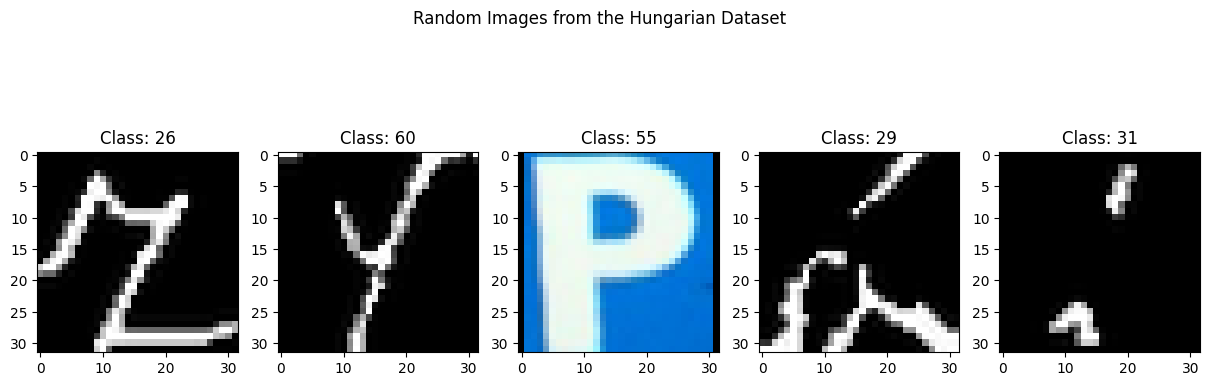

In [ ]:
import matplotlib.pyplot as plt
import random

# Assuming you have already created the HungarianDataModule instance and trained the model

# Access the train dataset
visualize_train_dataset = dm.train_dataset
visualize_labels = dm.class_labels

# Create a plot to display 5 random images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
fig.suptitle("Random Images from the Hungarian Dataset")

for i in range(5):
    # Randomly select an image and its label
    idx = random.randint(0, len(visualize_train_dataset) - 1)
    sample, label = visualize_train_dataset[idx]

    # Convert the tensor to a NumPy array and unnormalize it
    sample = sample.numpy().transpose((1, 2, 0))
    sample = 0.5 * sample + 0.5  # Unnormalize (assuming you used the same normalization)

    # Display the image and its label

    ax = axes[i]
    ax.imshow(sample)
    ax.set_title(f"Class: {visualize_labels[label]}")

# Show the plot
plt.show()

In [ ]:
import warnings

# Temporarily suppress deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Your code that triggers deprecation warnings

# Re-enable deprecation warnings (if needed)
#warnings.filterwarnings("default", category=DeprecationWarning)


INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type                      | Params
---------------------------------------------------------------
0 | confusion_matrix | MulticlassConfusionMatrix | 0     
1 | layers           | Sequential                | 1.6 M 
2 | accuracy         | MulticlassAccuracy        | 0     
---------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.463     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

acc,▁▂▄▂▁▄▅▅▅▇▅▆▆▇▇▆█▆█▇█▇▆▇▇▇█████▇▇▆███▇▇█
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▅▇▇▅▄▄▄▂▄▃▃▂▃▃▁▃▁▃▁▂▃▂▂▂▁▁▁▁▁▂▂▃▁▁▁▂▂▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▃▄▄▅▆▆▇▇▇▇▇▇▇██████████████████████████
val_loss,█▆▅▄▄▃▃▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.89844
epoch,100
global_step,83123
loss,3.37851


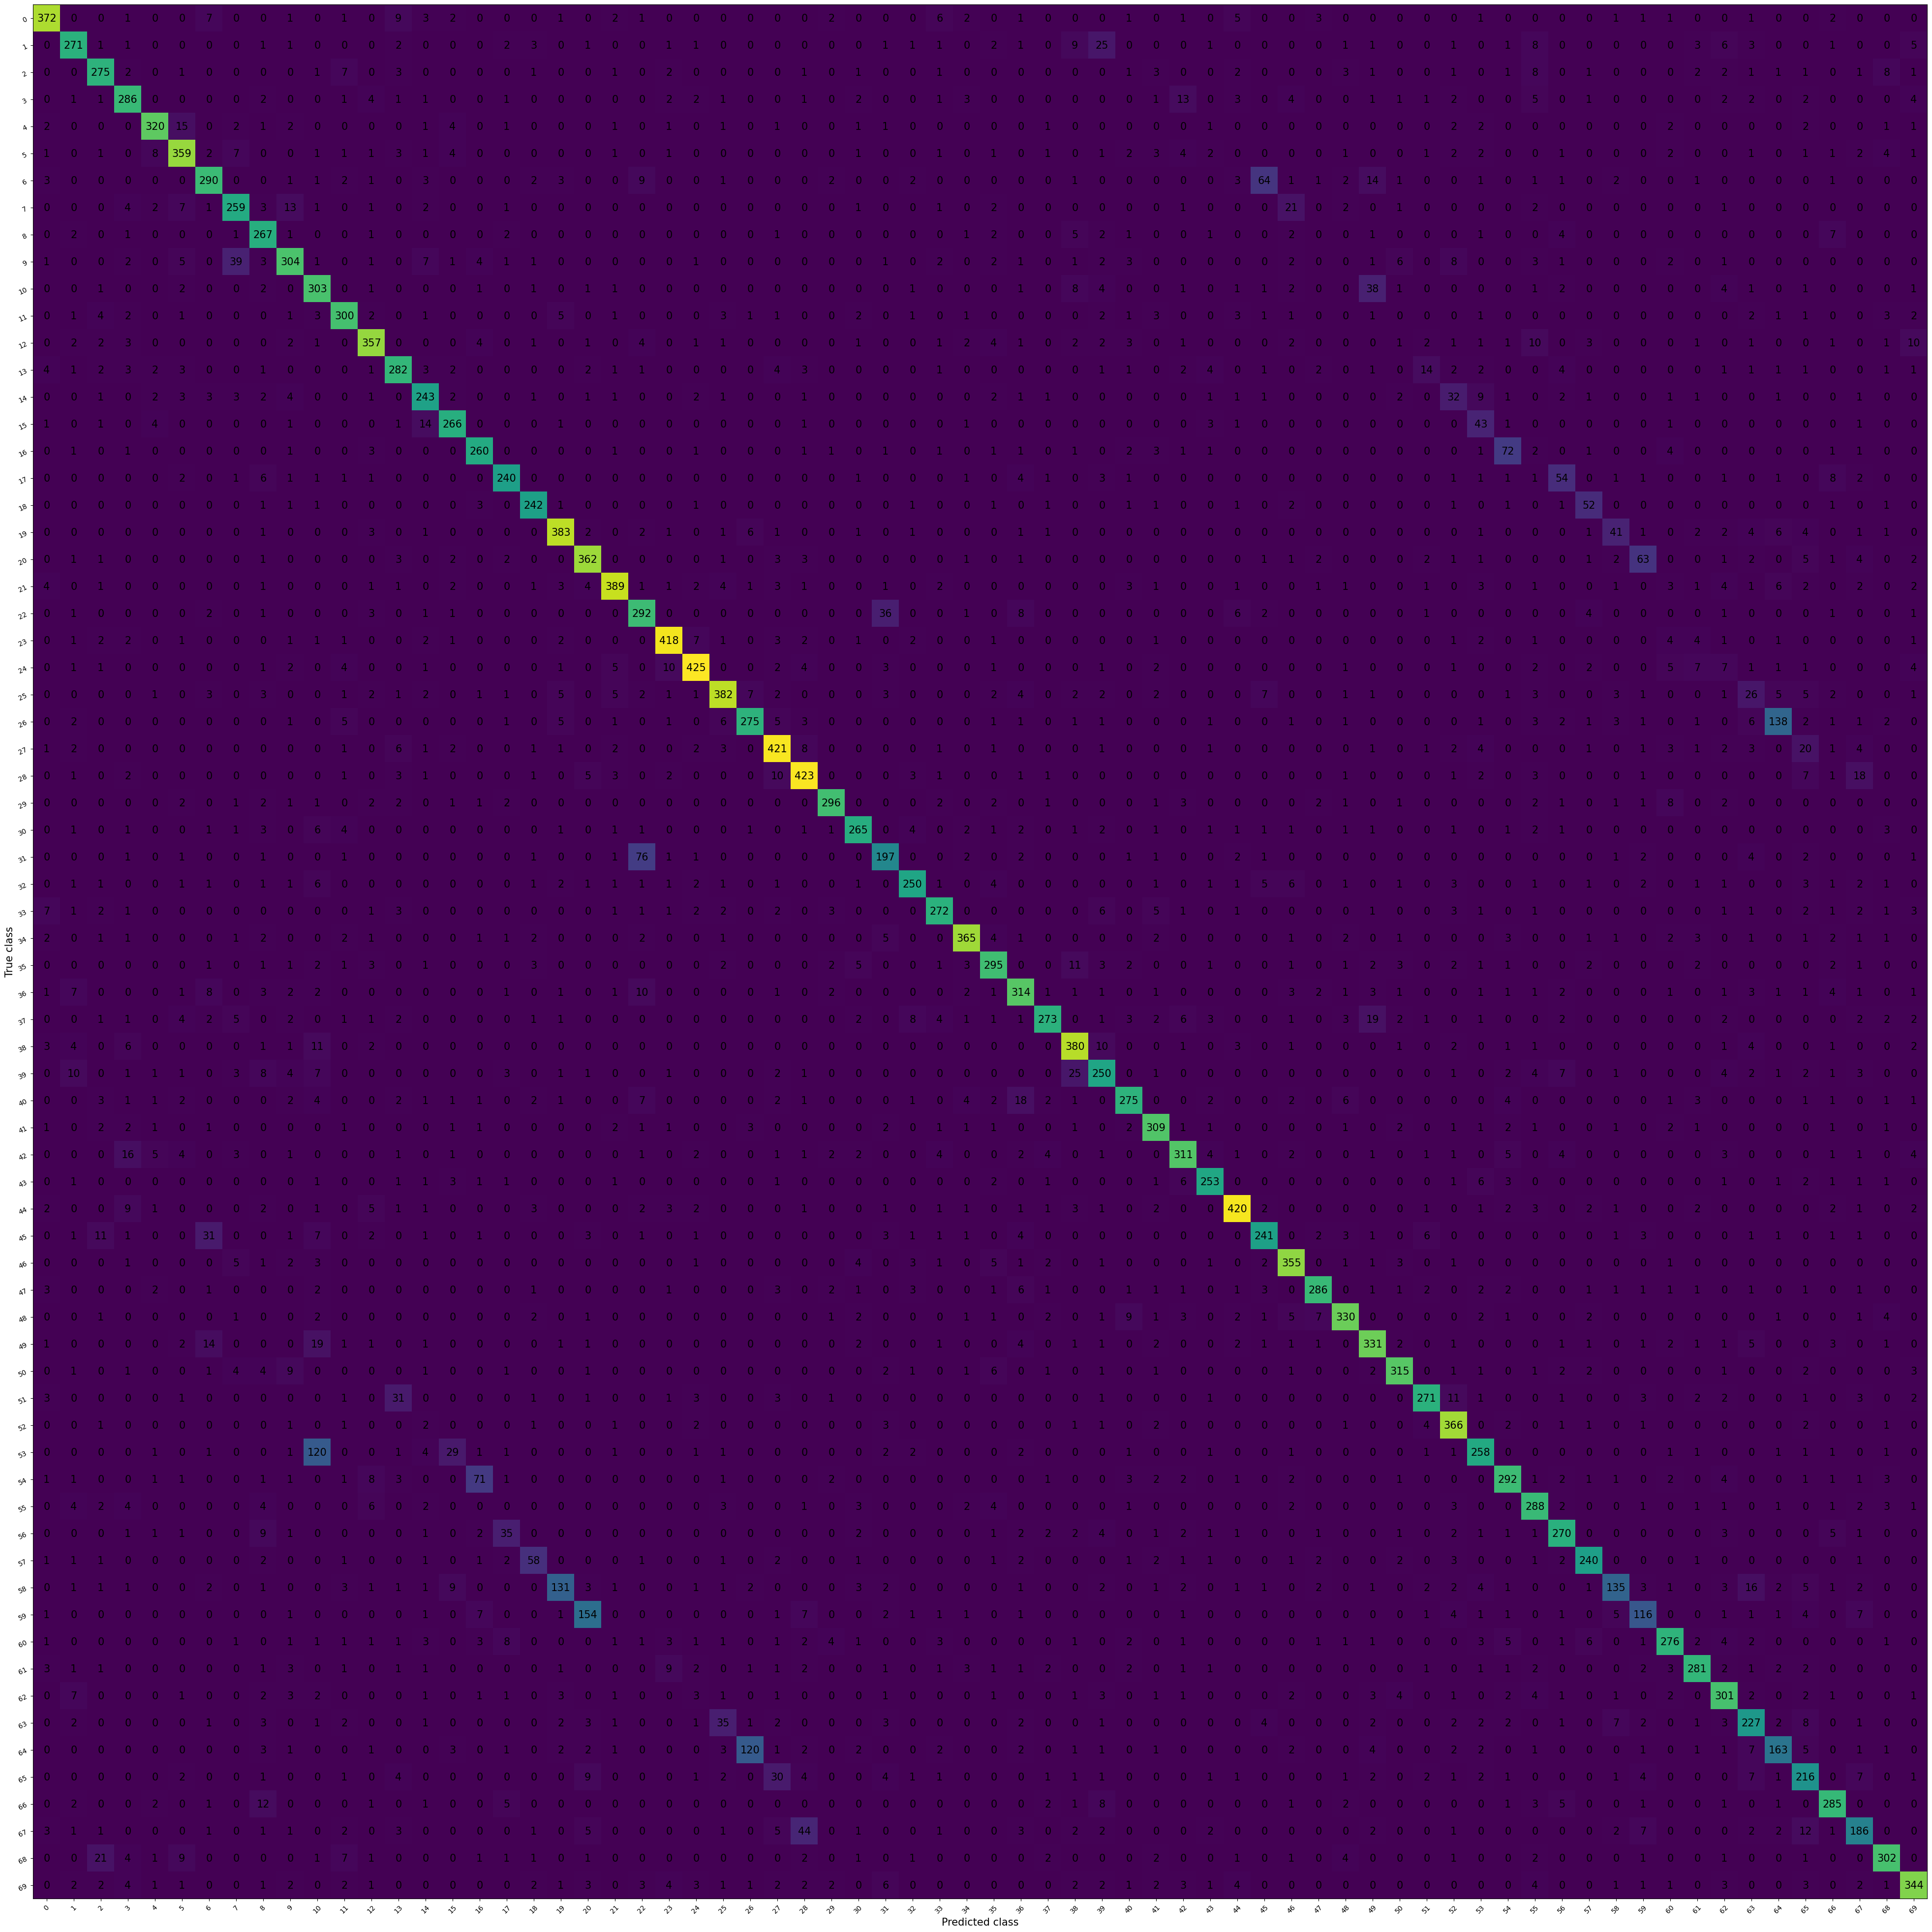

In [ ]:
# Train the model
trainer.fit(model, dm)
f,ax = plt.subplots(1,1,figsize=(50,50))
model.confusion_matrix.plot(ax=ax)
wandb.finish()

In [ ]:
##trainer.test(model, dm)
#f,ax = plt.subplots(1,1,figsize=(50,50))
#model.confusion_matrix.plot(ax=ax)